# Project 08: Epidemium - Summary
## Bloc n°6 - Jedha - dsmft - Paris14
### Joseph Abitbol & Nicolas Hegerle

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from func import *

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Dummy model metrics obtained for the ```mean model```, ```median model``` and ```random model```

In [5]:
#load the train data for verification
data = pd.read_csv("raw_data/KORL_avatar_train.csv", parse_dates=[3,4,6])
data.rename(columns = {col:col.lower() for col in data.columns}, inplace = True)
data.head()

#n supposed to be between 0 and 3 but have 2a, 2b, 2c => lets consider it all 2 for now
data['n'] = data['n'].apply(lambda x : 2 if x in ["2a", "2b", "2c"] else x)
data = data.astype({'n': 'int64'})

#columns to drop: no_info => patient_id & localisation. Highly correlated => age, date_biopsie, date_dernieres_nouvelles, alcool => a single non drinking patient
cols_to_drop = ["patient_id", "localisation", "age", "date_biopsie", "date_derniere_nouvelles", 'alcool']
to_keep = [col for col in data.columns if col not in cols_to_drop]
data = data[to_keep]

# split the data in X and y
y = data['os'].values
X = data[[col for col in data.columns if col != 'os']].values

# instantiate the dummy regressors
dr_mean = DummyRegressor(strategy = 'mean')
dr_median = DummyRegressor(strategy = 'median')

# fit the models to the data
dr_mean.fit(X, y)
dr_median.fit(X, y)

# get the scores for those dummy models
print("Mean Absolute Error for dummy model predicting mean: " ,mean_absolute_error(y, dr_mean.predict(X)))
print("Mean Squared Error for dummy model predicting mean: " ,mean_squared_error(y, dr_mean.predict(X)))
print("R2 score for dummy model predicting mean: " ,r2_score(y, dr_mean.predict(X)))


print("\nMean Absolute Error for dummy model predicting median: ", mean_absolute_error(y, dr_median.predict(X)))
print("Mean Squarred Error for dummy model predicting median: ", mean_squared_error(y, dr_median.predict(X)))
print("R2 score for dummy model predicting median: " ,r2_score(y, dr_median.predict(X)))

# lets see what a random prediction does
scores = {'mae': [], 'mse': [], 'r2': []}
for i in range(101):

    y_rand_pred = np.random.randint(y.min(), y.max(), len(y))
    mae = mean_absolute_error(y, y_rand_pred)
    mse = mean_squared_error(y, y_rand_pred)
    r2 = r2_score(y, y_rand_pred)

    scores['mae'].append(mae)
    scores['mse'].append(mse)
    scores['r2'].append(r2)

print(f"\nMean Absolute Error for randaom predictions: {round(np.mean(scores['mae']), 3)}, std = {round(np.std(scores['mae']), 3)}")
print(f"Mean Squarred Error ffor randaom predictions: {round(np.mean(scores['mse']), 3)}, std = {round(np.std(scores['mse']), 3)}")
print(f"R2 score for for randaom predictions: {round(np.mean(scores['r2']), 3)}, std = {round(np.std(scores['r2']), 3)}")


Mean Absolute Error for dummy model predicting mean:  25.561983471074374
Mean Squared Error for dummy model predicting mean:  811.1544421487604
R2 score for dummy model predicting mean:  0.0

Mean Absolute Error for dummy model predicting median:  24.84090909090909
Mean Squarred Error for dummy model predicting median:  919.9772727272727
R2 score for dummy model predicting median:  -0.13415796662623092

Mean Absolute Error for randaom predictions: 33.143, std = 3.18
Mean Squarred Error ffor randaom predictions: 1650.826, std = 256.064
R2 score for for randaom predictions: -1.035, std = 0.316


### Load all the individual dataframes for plotting and also concatenate all the prediction dataframes produced during model training

In [6]:
#Instantiate a dataframe to be populated with all the predictions made over model training
df_all_preds = pd.DataFrame()
df_list = []
# relative path to the folder containg all the subfolder and files of training prediction datas
top_dir = "src/pred_df" 

#Loop over all the folders containing all the predictions files 
for dir_path in os.listdir(top_dir):
    if dir_path[0]!= '.': # make sure to avoid any filename starting with '.'
        for pred_csv in os.listdir(f"{top_dir}/{dir_path}"): # loop over the csv files in each subfolder
            if pred_csv[0] != '.':
                
                split_name = pred_csv.split(".")[0].split("_")  #split the name of the file to get the info we need to fill up the columns
                df_filename = pred_csv.split(".")[0] #get the filenam without the .csv extension to use with globals()
                #load the dataframe as an individual global variable to access it later
                globals()[df_filename] = pd.read_csv(f"{top_dir}/{dir_path}/{pred_csv}")
                df_list.append(df_filename)

                df = pd.read_csv(f"{top_dir}/{dir_path}/{pred_csv}") # read the csv file into a dataframe




                # create new columns to be used later for plotting
                df['file_name'] = df_filename
                df['cell_type'] = split_name[0]
                df['model'] = split_name[1]
                df['img_set'] = split_name[-1]

                if ('3who' in split_name) or ('liimatainen' in split_name):
                    df['3who'] = 1
                else:
                    df['3who'] = 0

                if 'mse' in split_name:
                    df['loss'] = 'mse'
                else:
                    df['loss'] = 'mae'

                if 'liimatainen' in split_name:
                    df['trainable'] = 'base'
                else:
                    df['trainable'] = split_name[2]
                

                
                # concatenate all the datafames together
                df_all_preds = pd.concat([df_all_preds, df], ignore_index=True)


            

In [7]:
df_all_preds['3who'].unique()

array([1, 0])

In [8]:
# lets check if it seems coherent
print("Shape of the dataframe: ", df_all_preds.shape)
print("\nHead of the dataframe:")
display(df_all_preds.head())
print("\nSome info on the dataframe:")
display(df_all_preds.describe(include = 'all'))

Shape of the dataframe:  (255676, 11)

Head of the dataframe:


,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable
0,71,71,0,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct
1,71,85,14,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct
2,71,91,20,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct
3,71,96,25,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct
4,71,69,2,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct



Some info on the dataframe:


,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable
count,255676.000000,255676.000000,255676.000000,255676.000000,255676,255676,255676,255676,255676.000000,255676,255676
unique,NaN,NaN,NaN,NaN,162,8,5,3,NaN,2,3
top,NaN,NaN,NaN,NaN,ci5_IRNv2_20pct_3who_mse_val,all,IRNv2,train,NaN,mae,20pct
freq,NaN,NaN,NaN,NaN,2246,62179,111207,135120,NaN,218304,191779
mean,49.692541,48.558293,16.367262,49.816956,NaN,NaN,NaN,NaN,0.691618,NaN,NaN
std,30.067059,26.428250,17.139731,29.990566,NaN,NaN,NaN,NaN,0.461826,NaN,NaN
min,0.000000,-1368.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,21.000000,27.000000,4.000000,21.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
50%,56.000000,50.000000,10.000000,56.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
75%,78.000000,68.000000,24.000000,78.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN


In [9]:
df_stats = df_all_preds[df_all_preds['3who'] == 1]
df_stats['x_label'] = df_stats['file_name'].apply(lambda x : \
    ('_').join(x.split('_')[0:3])+'_mse' if 'mse' in x.split('_') else x.split('_')[0]+"_ConvNet" if 'liimatainen' in x.split('_') else ('_').join(x.split('_')[0:3]))
df_stats.head()

/var/folders/16/4bnr3kp950g2168ghl5qt2v00000gn/T/ipykernel_21085/1179896807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats['x_label'] = df_stats['file_name'].apply(lambda x : \


,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
0,71,71,0,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
1,71,85,14,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
2,71,91,20,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
3,71,96,25,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
4,71,69,2,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct


In [10]:
df_all_train = df_stats[df_stats['img_set'] == "train"]
df_all_train.reset_index(drop=True, inplace=True)
df_all_train.head()

,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
0,71,71,0,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
1,71,85,14,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
2,71,91,20,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
3,71,96,25,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct
4,71,69,2,71,ci3_DN201_20pct_3who_train,ci3,DN201,train,1,mae,20pct,ci3_DN201_20pct


In [11]:
# calculate the minimum mae
train_mae_stat = df_all_train.groupby(by = 'file_name', as_index = False)['abs_error'].agg(['mean', 'std'])
train_mae_stat.reset_index(drop = False, inplace = True)
max_mae_10_best = train_mae_stat['mean'].sort_values(ascending = True)[ :10].max()
train_min_mae = train_mae_stat['mean'].min()
mask = train_mae_stat['mean'] <= max_mae_10_best

train_mae_stat = train_mae_stat.loc[mask]
train_mae_stat.sort_values(by = 'mean', ascending = True, inplace = True)
rows_to_keep = train_mae_stat['file_name']

df_all_train = df_all_train[df_all_train['file_name'].isin(rows_to_keep)]

train_mae_stat['x_label'] = train_mae_stat['file_name'].apply(lambda x : \
    ('_').join(x.split('_')[0:3])+'_mse' if 'mse' in x.split('_') else x.split('_')[0]+"_ConvNet" if 'liimatainen' in x.split('_') else ('_').join(x.split('_')[0:3]))

train_mae_stat

,file_name,mean,std,x_label
32,cti3_Iv3_20pct_3who_train,3.205447,3.290119,cti3_Iv3_20pct
42,st_Iv3_20pct_3who_train,3.761622,3.490930,st_Iv3_20pct
6,all_Iv3_20pct_3who_train,3.879910,5.157066,all_Iv3_20pct
17,ci2_Iv3_20pct_3who_train,4.109412,3.510020,ci2_Iv3_20pct
22,ci3_Iv3_20pct_3who_train,4.121711,3.788700,ci3_Iv3_20pct
3,all_IRNv2_20pct_3who_train,4.293454,8.230236,all_IRNv2_20pct
2,all_IRNv2_20pct_3who_mse_train,4.336343,5.307884,all_IRNv2_20pct_mse
37,cti6_Iv3_20pct_3who_train,4.648426,5.027866,cti6_Iv3_20pct
21,ci3_IRNv2_20pct_3who_train,5.315179,5.689741,ci3_IRNv2_20pct
15,ci2_IRNv2_20pct_3who_mse_train,5.570963,5.773278,ci2_IRNv2_20pct_mse


In [12]:
df_all_train.head()

,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
25488,67,68,1,67,ci2_IRNv2_20pct_3who_mse_train,ci2,IRNv2,train,1,mse,20pct,ci2_IRNv2_20pct_mse
25489,67,69,2,67,ci2_IRNv2_20pct_3who_mse_train,ci2,IRNv2,train,1,mse,20pct,ci2_IRNv2_20pct_mse
25490,67,67,0,67,ci2_IRNv2_20pct_3who_mse_train,ci2,IRNv2,train,1,mse,20pct,ci2_IRNv2_20pct_mse
25491,67,59,8,67,ci2_IRNv2_20pct_3who_mse_train,ci2,IRNv2,train,1,mse,20pct,ci2_IRNv2_20pct_mse
25492,67,67,0,67,ci2_IRNv2_20pct_3who_mse_train,ci2,IRNv2,train,1,mse,20pct,ci2_IRNv2_20pct_mse


In [13]:
order = [x for x in train_mae_stat['x_label']]
order

['cti3_Iv3_20pct',
 'st_Iv3_20pct',
 'all_Iv3_20pct',
 'ci2_Iv3_20pct',
 'ci3_Iv3_20pct',
 'all_IRNv2_20pct',
 'all_IRNv2_20pct_mse',
 'cti6_Iv3_20pct',
 'ci3_IRNv2_20pct',
 'ci2_IRNv2_20pct_mse']

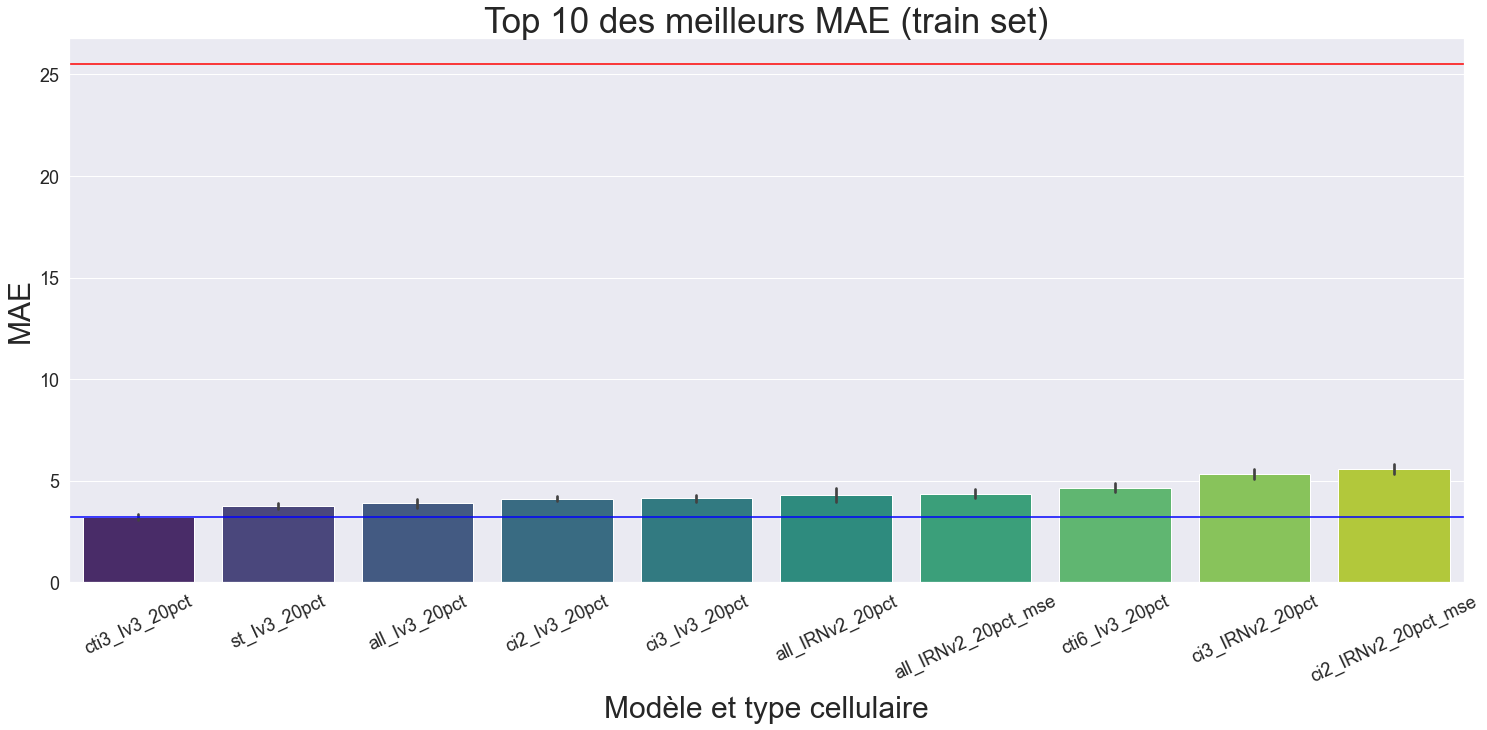

In [14]:
sns.set_theme(style = 'darkgrid')
plt.figure(figsize = (25, 10))
plt.xticks(rotation=25)


b = sns.barplot(data = df_all_train, x = 'x_label', y = 'abs_error', palette = 'viridis', order = order)
plt.axhline(25.5, color = 'red')
plt.axhline(train_min_mae, color = 'blue')

b.axes.set_title("Top 10 des meilleurs MAE (train set)",fontsize=35)
b.set_xlabel("Modèle et type cellulaire",fontsize=30, labelpad = 10)
b.set_ylabel("MAE",fontsize=30)
b.tick_params(labelsize=18)

plt.savefig("Train_mae_graph.png", dpi = 300)


In [15]:
df_all_val = df_stats[df_stats['img_set'] == "val"]
df_all_val.reset_index(drop=True, inplace=True)
df_all_val.head()

,true,pred,abs_error,os,file_name,cell_type,model,img_set,3who,loss,trainable,x_label
0,27,59,32,27,ci5_DN201_20pct_3who_val,ci5,DN201,val,1,mae,20pct,ci5_DN201_20pct
1,27,48,21,27,ci5_DN201_20pct_3who_val,ci5,DN201,val,1,mae,20pct,ci5_DN201_20pct
2,27,44,17,27,ci5_DN201_20pct_3who_val,ci5,DN201,val,1,mae,20pct,ci5_DN201_20pct
3,27,68,41,27,ci5_DN201_20pct_3who_val,ci5,DN201,val,1,mae,20pct,ci5_DN201_20pct
4,27,47,20,27,ci5_DN201_20pct_3who_val,ci5,DN201,val,1,mae,20pct,ci5_DN201_20pct


In [16]:
# calculate the minimum mae
val_mae_stat = df_all_val.groupby(by = 'file_name', as_index = False)['abs_error'].agg(['mean', 'std'])
val_mae_stat.reset_index(drop = False, inplace = True)
max_mae_10_best = val_mae_stat['mean'].sort_values(ascending = True)[ :10].max()
val_min_mae = val_mae_stat['mean'].min()
mask = val_mae_stat['mean'] <= max_mae_10_best

val_mae_stat = val_mae_stat.loc[mask]
val_mae_stat.sort_values(by = 'mean', ascending = True, inplace = True)
rows_to_keep = val_mae_stat['file_name']

df_all_val = df_all_val[df_all_val['file_name'].isin(rows_to_keep)]

val_mae_stat['x_label'] = val_mae_stat['file_name'].apply(lambda x : \
    ('_').join(x.split('_')[0:3])+'_mse' if 'mse' in x.split('_') else x.split('_')[0]+"_ConvNet" if 'liimatainen' in x.split('_') else ('_').join(x.split('_')[0:3]))

val_mae_stat


,file_name,mean,std,x_label
3,all_IRNv2_20pct_3who_val,15.687982,20.277156,all_IRNv2_20pct
2,all_IRNv2_20pct_3who_mse_val,16.738776,19.011597,all_IRNv2_20pct_mse
6,all_Iv3_20pct_3who_val,16.828118,19.418683,all_Iv3_20pct
32,cti3_Iv3_20pct_3who_val,18.224503,16.898349,cti3_Iv3_20pct
34,cti6_DN201_20pct_3who_val,18.985640,15.885072,cti6_DN201_20pct
36,cti6_IRNv2_20pct_3who_val,19.275281,17.502130,cti6_IRNv2_20pct
0,all_DN201_20pct_3who_val,19.352381,16.053693,all_DN201_20pct
16,ci2_IRNv2_20pct_3who_val,19.560339,18.781756,ci2_IRNv2_20pct
22,ci3_Iv3_20pct_3who_val,19.743606,14.837228,ci3_Iv3_20pct
31,cti3_IRNv2_20pct_3who_val,20.029885,20.181115,cti3_IRNv2_20pct


In [17]:
val_mae_stat['file_name'].unique()

array(['all_IRNv2_20pct_3who_val', 'all_IRNv2_20pct_3who_mse_val',
       'all_Iv3_20pct_3who_val', 'cti3_Iv3_20pct_3who_val',
       'cti6_DN201_20pct_3who_val', 'cti6_IRNv2_20pct_3who_val',
       'all_DN201_20pct_3who_val', 'ci2_IRNv2_20pct_3who_val',
       'ci3_Iv3_20pct_3who_val', 'cti3_IRNv2_20pct_3who_val'],
      dtype=object)

In [18]:
order = [x for x in val_mae_stat['x_label']]
order

['all_IRNv2_20pct',
 'all_IRNv2_20pct_mse',
 'all_Iv3_20pct',
 'cti3_Iv3_20pct',
 'cti6_DN201_20pct',
 'cti6_IRNv2_20pct',
 'all_DN201_20pct',
 'ci2_IRNv2_20pct',
 'ci3_Iv3_20pct',
 'cti3_IRNv2_20pct']

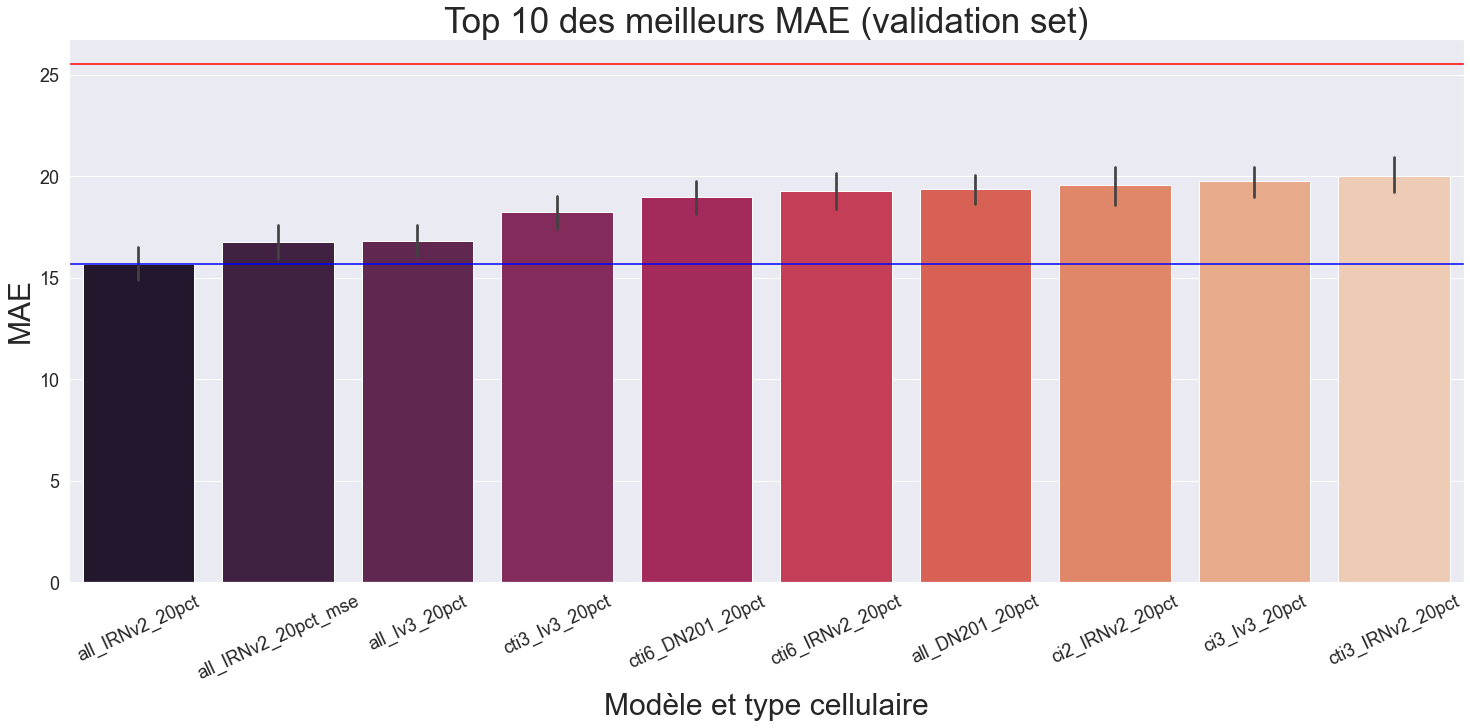

In [19]:
sns.set_theme(style = 'darkgrid')
plt.figure(figsize = (25, 10))
plt.xticks(rotation=25)

b = sns.barplot(data = df_all_val, x = 'x_label', y = 'abs_error', palette = 'rocket', order = order)
plt.axhline(25.5, color = 'red')
plt.axhline(val_min_mae, color = 'blue')

b.axes.set_title("Top 10 des meilleurs MAE (validation set)",fontsize=35)
b.set_xlabel("Modèle et type cellulaire",fontsize=30, labelpad = 10)
b.set_ylabel("MAE",fontsize=30)
b.tick_params(labelsize=18)

plt.savefig("Val_mae_graph.png", dpi = 300)

In [20]:
df_irnv2_train = pd.read_csv("src/pred_df/InceptionResNetV2_tl_3who_preds/all_IRNv2_20pct_3who_train.csv")
df_irnv2_val = pd.read_csv("src/pred_df/InceptionResNetV2_tl_3who_preds/all_IRNv2_20pct_3who_val.csv")
#df_all_iv3_20pct_3who_test = pd.read_csv("src/pred_df/InceptionV3_tl_3who_preds/all_Iv3_20pct_3who_test.csv")

df_irnv2_train['set'] = 'train'
df_irnv2_val['set'] = 'val'
df_all_irnv2 = pd.concat([df_irnv2_train, df_irnv2_val])
df_all_irnv2.reset_index(drop=True, inplace = True)

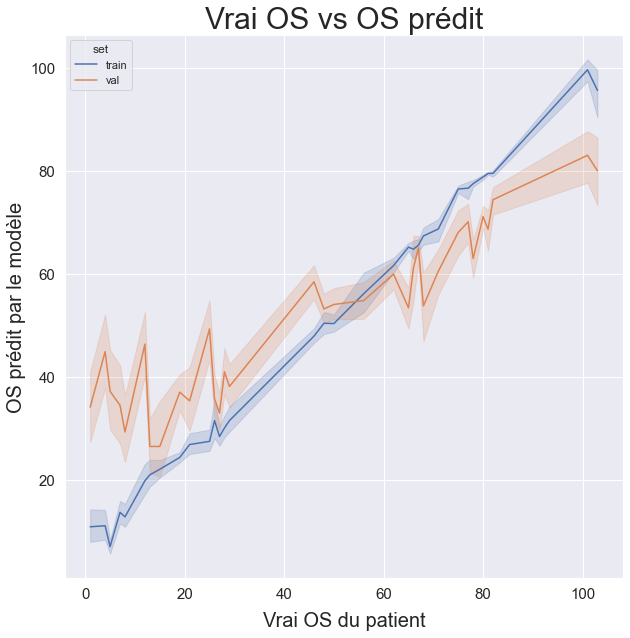

In [21]:
sns.set_theme(style = 'darkgrid')
plt.figure(figsize = (10, 10))
plt.xticks(rotation=0)

b = sns.lineplot(data = df_all_irnv2, x = 'true', y = 'pred', hue='set')

b.axes.set_title("Vrai OS vs OS prédit",fontsize=30)
b.set_xlabel("Vrai OS du patient",fontsize=20, labelpad = 10)
b.set_ylabel("OS prédit par le modèle",fontsize=20)
b.tick_params(labelsize=15)

plt.savefig("True_OS_vs_pred.png", dpi = 300)

In [55]:
df_irnv2_base_train = pd.read_csv("src/pred_df/InceptionResNetV2_tl_preds/all_IRNv2_base_train.csv")
df_irnv2_base_val = pd.read_csv("src/pred_df/InceptionResNetV2_tl_preds/all_IRNv2_base_val.csv")
df_irnv2_train = pd.read_csv("src/pred_df/InceptionResNetV2_tl_preds/all_IRNv2_20pct_train.csv")
df_irnv2_val = pd.read_csv("src/pred_df/InceptionResNetV2_tl_preds/all_IRNv2_20pct_val.csv")
df_all = pd.read_csv("src/train/train_img_data.csv")

In [98]:
def plot_summary_stats(train_dfs, val_dfs, row_names, width = 50, height = 30):

    '''
    Plots the summary statistics of multiple dataframes (at least 2) generated by the <generate_predictions> function and returns a figure object

    Arguments:
    train_dfs: list, a list of the dataframes generated by <generate_predictions> on the iterations of the train image generator you want to plot
    val_dfs: list, a list of the dataframes generated by <generate_predictions> on the iterations of the validation image generator you want to plot
    row_names: list, the names you want to give to the rows of the subplots.
    !!! len(train_dfs) == len(val_dfs) == len(row_names)
    width/height: the dimension of the figure object
    df_train: the dataframe generated by <generate_predictions> on the iterations of the train image generator
    df_val: the dataframe generated by <generate_predictions> on the iterations of the val image generator
    cell_type: if provided should be one of the cell_types under the <raw_img_dir> of the initial dataset
    width/height= dimensions of the figure

    Returns:
    fig, ax
    Matplotlib figure and axes objects
    '''

    #verify dataframe sizes and retrieve max prediction value and nb of rows to plot
    nb_rows = len(train_dfs)
    max_pred = []

    for tr_df in train_dfs:
        max_pred.append(tr_df['pred'].max())
        for v_df in val_dfs:
            assert tr_df.shape[1] == v_df.shape[1] 
            max_pred.append(v_df['pred'].max())

    max_pred = max(max_pred) + 1
    max_os = train_dfs[0]['os'].max() + 1

    assert nb_rows == len(val_dfs)
    assert nb_rows == len(row_names)



    sns.set_style("darkgrid") #set style of the graphs

    fig, ax =plt.subplots(nrows = nb_rows, ncols = 3, figsize = (width, height)) #create a figure object with a len(df_list) rows by 6 columns subplot grid


    cols = ['OS prédit', 
    'Vrai OS vs OS prédit', \
    'Erreur absolue OS vrai / OS prédit'
    ]

    if nb_rows > 1:
        for axe, col in zip(ax[0], cols):
            axe.set_title(col, fontweight = 'bold', size = 30)



# Plot the histplots of the labels found in the train data from 30 iterations of the train generator on the first column
    if nb_rows > 1:

        for row, df in enumerate(val_dfs):
            sns.histplot(data = df, x = 'pred', ax=ax[row, 0], discrete = True, binrange = (0, max_pred), kde=True, color = '#0E3449', alpha = 0.5)
            ax[row, 0].set(xlim=(0, max_pred))
            sns.boxplot(data = df, x = 'true', y = 'pred', ax = ax[row, 1], palette = 'rocket')
            ax[row, 1].set(ylim=(0, max_pred))
            ax[row, 1].tick_params(labelrotation=90)
            sns.boxplot(data = df, x = 'os', y = 'abs_error', ax=ax[row, 2], palette = 'rocket')
            ax[row, 2].set(ylim=(0, max_pred))
            ax[row, 2].tick_params(labelrotation=90)

        for axe, row in zip(ax[:,0], row_names):
            axe.set_ylabel(row, fontsize = 30)

    return fig, ax

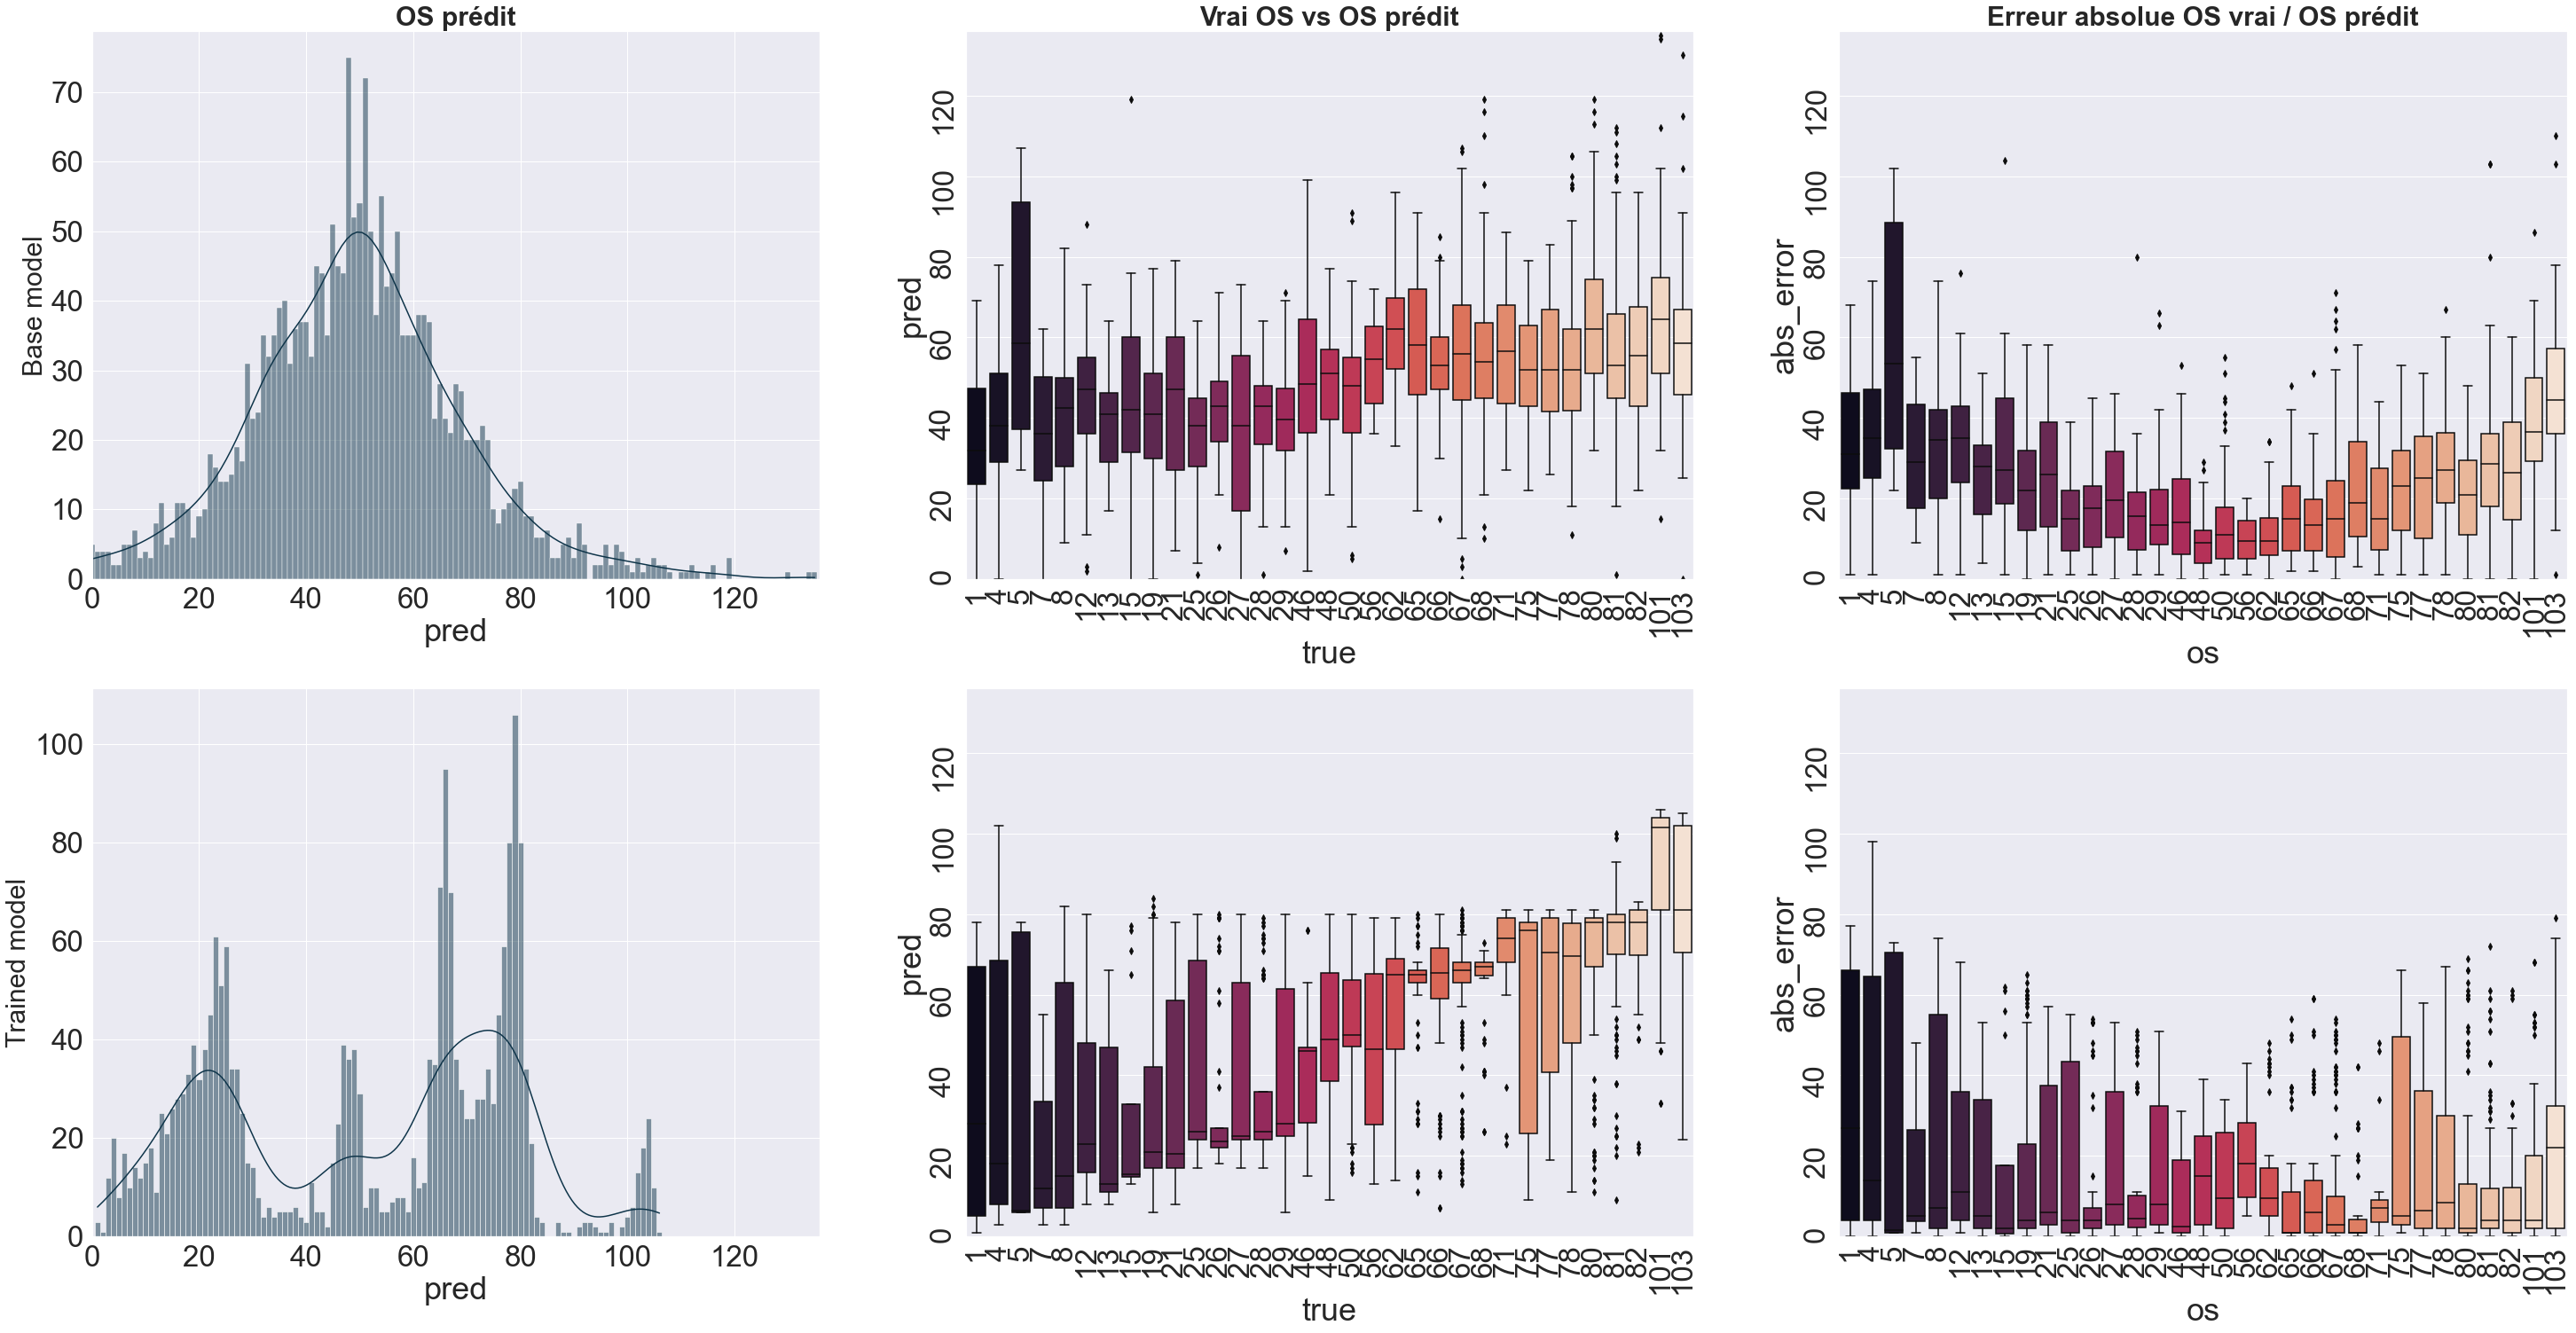

In [99]:
fig, ax = plot_summary_stats([df_irnv2_base_train, df_irnv2_train], [df_irnv2_base_val, df_irnv2_val], ["Base model", "Trained model"], width = 50, height = 25)
plt.savefig("IRNv2_trainin.png", dpi = 300)